<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/randomforest/regression/04_random_quantile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skranger

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

from skranger.ensemble import RangerForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold

import multiprocessing

In [ ]:
# Simulación

n = 3000
X = np.linspace(start=0, stop=24, num=n)
X

array([0.00000000e+00, 8.00266756e-03, 1.60053351e-02, ...,
       2.39839947e+01, 2.39919973e+01, 2.40000000e+01])

In [ ]:
# Distribución normal con varianza cambiante
y = np.random.normal(
    loc = 15,
      scale = 1 + 1.5*((4.8 < X) & (X < 7.2)) + 4*((7.2 < X) & (X < 12)) \
                + 1.5*((12 < X) & (X < 14.4)) + 2*(X > 16.8)
)

In [ ]:
# cuantil 0.1 y 0.9 para cada posición de x simulada.
cuantil_10 = norm.ppf(
    q = 0.1,
    loc   = 15,
    scale = 1 + 1.5*((4.8 < X) & (X < 7.2)) + 4*((7.2 < X) & (X < 12)) \
            + 1.5*((12 < X) & (X < 14.4)) + 2*(X > 16.8)
)

cuantil_90 = norm.ppf(
    q = 0.9,
    loc   = 15,
    scale = 1 + 1.5*((4.8 < X) & (X < 7.2)) + 4*((7.2 < X) & (X < 12)) \
            + 1.5*((12 < X) & (X < 14.4)) + 2*(X > 16.8)
)

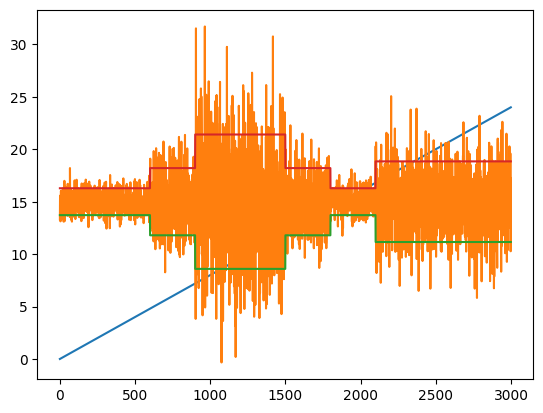

In [ ]:
plt.plot(X)
plt.plot(y)
plt.plot(cuantil_10)
plt.plot(cuantil_90)

In [ ]:
X.reshape(-1, 1)

array([[0.00000000e+00],
       [8.00266756e-03],
       [1.60053351e-02],
       ...,
       [2.39839947e+01],
       [2.39919973e+01],
       [2.40000000e+01]])

In [ ]:
param_grid = {
    'n_estimators' : [500, 1000, 2000],
    'min_node_size' : [25, 50, 100, 200]
}

In [ ]:
grid = GridSearchCV(
    estimator = RangerForestRegressor(seed=12354, quantiles=True),
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=12354),
    refit = True,
    verbose = 0,
    return_train_score = True
)

grid.fit(X = X.reshape(-1, 1), y = y)


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=12354),
             estimator=RangerForestRegressor(quantiles=True, seed=12354),
             n_jobs=1,
             param_grid={'min_node_size': [25, 50, 100, 200],
                         'n_estimators': [500, 1000, 2000]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)').drop(
    columns = 'params').sort_values(
        'mean_test_score', ascending = False)

,param_min_node_size,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
9,200,500,-3.136960,0.123360,-2.846769,0.037429
10,200,1000,-3.137140,0.123183,-2.847459,0.037461
11,200,2000,-3.137615,0.123310,-2.848246,0.037934
7,100,1000,-3.169999,0.120712,-2.773918,0.034765
8,100,2000,-3.170302,0.120995,-2.773696,0.035050
6,100,500,-3.170924,0.121398,-2.773456,0.034263
5,50,2000,-3.219934,0.119740,-2.642904,0.032572
4,50,1000,-3.220093,0.118893,-2.643425,0.032951
3,50,500,-3.220697,0.119897,-2.643074,0.033016
2,25,2000,-3.295351,0.115864,-2.446168,0.029583


In [ ]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'min_node_size': 200, 'n_estimators': 500} : -3.136959966680364 neg_root_mean_squared_error


In [ ]:
grid_X = np.linspace(start=min(X), stop=max(X), num=5000)
grid_X = grid_X.reshape(-1, 1)

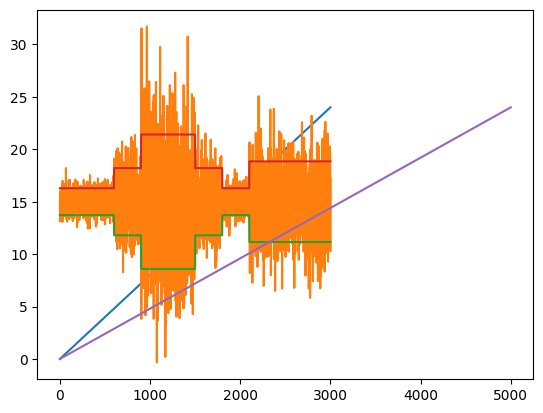

In [ ]:
plt.plot(X)
plt.plot(y)
plt.plot(cuantil_10)
plt.plot(cuantil_90)
plt.plot(grid_X)

In [ ]:
y_pre = modelo_final.predict_quantiles(
    X = grid_X,
    quantiles = [0.1, 0.9]
)

In [ ]:
y_pre.transpose()

array([[13.32250961, 13.28595485, 13.28595485, ..., 10.37659712,
        10.37659712, 10.37659712],
       [15.92967823, 16.03362531, 16.03362531, ..., 18.92158432,
        18.92158432, 18.92158432]])

In [ ]:
y_pre.T

array([[13.32250961, 13.28595485, 13.28595485, ..., 10.37659712,
        10.37659712, 10.37659712],
       [15.92967823, 16.03362531, 16.03362531, ..., 18.92158432,
        18.92158432, 18.92158432]])

In [ ]:
pred_cuantiles = pd.DataFrame(y_pre, columns=['q_01', 'q_90'])
pred_cuantiles

,q_01,q_90
0,13.322510,15.929678
1,13.285955,16.033625
2,13.285955,16.033625
3,13.285955,16.033625
4,13.285955,16.033625
...,...,...
4995,12.135212,19.608443
4996,12.017434,19.608443
4997,10.376597,18.921584
4998,10.376597,18.921584


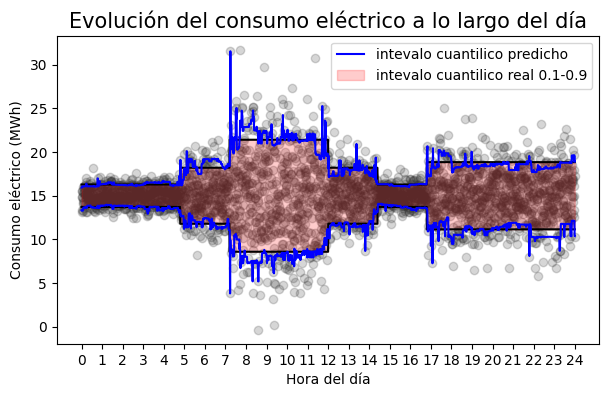

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
ax.scatter(X, y, alpha = 0.2, c = "#333")
ax.plot(X, cuantil_10, c = "black")
ax.plot(X, cuantil_90, c = "black")
ax.plot(grid_X, pred_cuantiles.q_01, c = "blue", label='intevalo cuantilico predicho')
ax.plot(grid_X, pred_cuantiles.q_90, c = "blue")
ax.fill_between(X, cuantil_10, cuantil_90, alpha=0.2, color='red',
                label='intevalo cuantilico real 0.1-0.9')
ax.set_xticks(range(0,25))
ax.set_title('Evolución del consumo eléctrico a lo largo del día',
             fontdict={'fontsize':15})
ax.set_xlabel('Hora del día')
ax.set_ylabel('Consumo eléctrico (MWh)')
plt.legend();